In [20]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import pandas as pd
from skimage.io import imread
import os
import numpy as np

image_size = (768, 768) #(512,512) (720, 1280)
better_model = False
load_pretrained_weights = False

In [21]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 3
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 1000
AUGMENT_BRIGHTNESS = False

ship_dir = '/mnt/fsx/airbus_data/deep_learning_v2'
train_image_dir = os.path.join(ship_dir, 'train')
from skimage.morphology import label


In [22]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [23]:
masks1 = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_train.csv.exp'))

print(masks1.shape[0], 'masks found')
print(masks1['ImageId'].value_counts().shape[0])
masks1.head()

999 masks found
519


,ImageId,EncodedPixels
0,000155de5_f6248d89-63c8-4b6b-bf48-bc76a1113538...,287464 2 288232 4 288999 7 289767 9 290535 12 ...
1,000194a2d_8d25adc5-48c0-4d7b-97ec-7d40cfc084a3...,93243 2 94008 6 94774 8 95542 8 96310 9 97079 ...
2,000194a2d_8d25adc5-48c0-4d7b-97ec-7d40cfc084a3...,370690 2 371457 4 371462 2 372226 6 372993 6 3...
3,000194a2d_8d25adc5-48c0-4d7b-97ec-7d40cfc084a3...,189490 4 190255 7 191021 10 191790 9 192558 9 ...
4,000194a2d_8d25adc5-48c0-4d7b-97ec-7d40cfc084a3...,244036 2 244800 7 245567 8 246333 10 247098 14...


In [26]:
masks2 = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_train.csv.exp.1'))

print(masks2.shape[0], 'masks found')
print(masks2['ImageId'].value_counts().shape[0])
masks2.head()

1 masks found
1


,ImageId,EncodedPixels
0,000194a2d_8d25adc5-48c0-4d7b-97ec-7d40cfc084a3...,93243 2 94008 6 94774 8 95542 8 96310 9 97079 ...


In [24]:
test_img_name="000194a2d_8d25adc5-48c0-4d7b-97ec-7d40cfc084a3.jpg"
test_img = imread("{}/{}".format(train_image_dir, test_img_name))

Text(0.5, 1.0, 'Original Image')

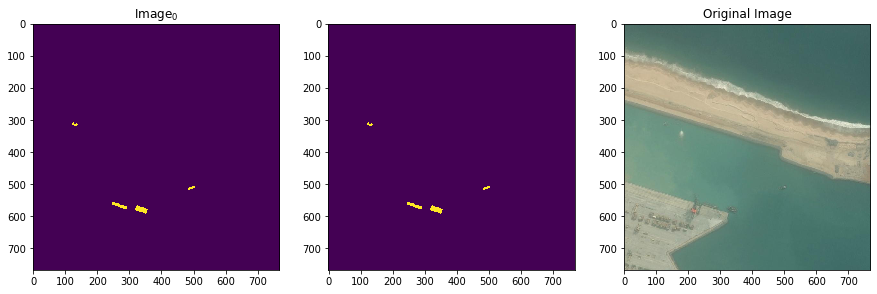

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
rle_0 = masks1.query('ImageId=="{}"'.format(test_img_name))['EncodedPixels'] # an efficient way to filter against pandas dataframe
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = masks2.query('ImageId=="{}"'.format(test_img_name))['EncodedPixels'] # an efficient way to filter against pandas dataframe
img_1 = masks_as_image(rle_1)
ax2.imshow(img_0[:, :, 0])
orig_img = plt.imread(os.path.join(train_image_dir, test_img_name))
ax3.imshow(orig_img)
ax3.set_title('Original Image')